# Transfer Learning Example: Alpaca

We aim to train a *binary classifier* on the [Alpaca images](https://www.kaggle.com/datasets/sid4sal/alpaca-dataset-small) dataset, which contains two classes of pictures: (i) pictures of Alpaca, (ii) pictures NOT containing Alpaca.

This dataset only contains a few hundreds pictures! Not enough for training a deep CNN from scratch (not to mention the memory requirement of a complete training).

We apply transfer learning on a pre-trained MobileNetV2 model.

## Getting Data

Download the dataset from the class materials and unzip it.

In [3]:
DATASET_ZIP="/home/gabriele/datasets/alpaca-dataset.zip"
DATASET_EXTRACT_DIR="/tmp/alpaca/"

import os
import zipfile
with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
    zip_ref.extractall(DATASET_EXTRACT_DIR)

DATASET_DIR = os.path.join(DATASET_EXTRACT_DIR, "dataset")

In [4]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_color_image(image):
    fig = plt.figure()
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

2024-11-12 12:50:25.477715: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 12:50:25.496660: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
import imageio

def process_img (filename, model):
    image = imageio.imread(filename)
    resized = tf.image.resize([image], (224,224))

    inputs = keras.applications.mobilenet_v2.preprocess_input(resized)
    Y_proba = model.predict(inputs)
    top_K = keras.applications.mobilenet_v2.decode_predictions(Y_proba, top=1)
    for image_index in range(len(resized)):
        print("Image #{}".format(image_index))
        for class_id, name, y_proba in top_K[image_index]:
            print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
        print()

In [5]:
model = keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet")

Let's see what the CNN, trained on ImageNet, predicts for Alpaca pictures:

In [10]:
import os
filenames=[]
DIR=os.path.join(DATASET_DIR,"alpaca")
for entry in os.listdir(DIR):
    if "jpg" in entry:
        filenames.append(os.path.join(DIR,entry))
for filename in filenames[:20]:
    process_img(filename, model)

/tmp/ipykernel_4361/1247954274.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
Image #0
  n02437616 - llama        15.44%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image #0
  n02437616 - llama        75.91%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Image #0
  n01855672 - goose        16.34%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image #0
  n02437616 - llama        96.42%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image #0
  n02437616 - llama        44.98%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image #0
  n02437616 - llama        94.11%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image #0
  n02437616 - llama        44.47%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image #0
  n02105641 - Old_English_sheepdog 40.87%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image #0
  n02437616 - llama        97.47%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image #0
  n02412080 - ram          31.51%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image #0
  n02437616 - llama        73.44%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image #0
  n02437616 - llama        94.22%

1/1 ━━━

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_DIR,
  validation_split=0.2,
      subset="training",
  seed=123,
  image_size=(224, 224),
  batch_size=16)
validation_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(224, 224),
  batch_size=16)


Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)


['alpaca', 'not alpaca']


2024-11-12 12:54:16.377017: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


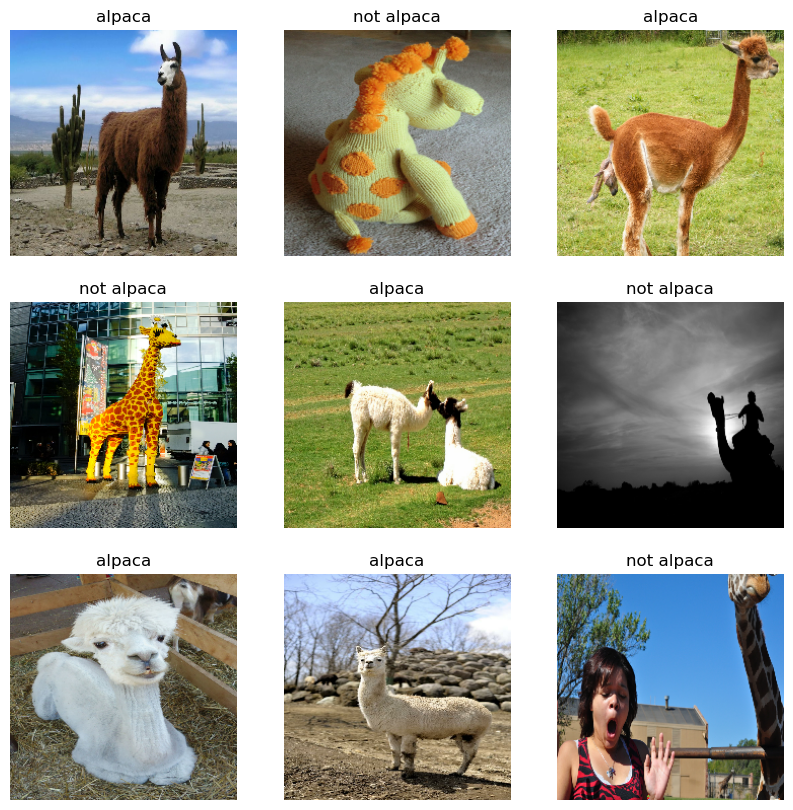

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [14]:
base_model = keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))

# Pre-trained model requires input to be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
newmodel = keras.Model(inputs, outputs)

newmodel.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
newmodel.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 100
newmodel.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - binary_accuracy: 0.5566 - loss: 0.7914 - val_binary_accuracy: 0.7692 - val_loss: 0.4818
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - binary_accuracy: 0.8250 - loss: 0.4130 - val_binary_accuracy: 0.8923 - val_loss: 0.3340
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - binary_accuracy: 0.9258 - loss: 0.2580 - val_binary_accuracy: 0.9231 - val_loss: 0.2727
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - binary_accuracy: 0.9799 - loss: 0.1878 - val_binary_accuracy: 0.9692 - val_loss: 0.2347
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - binary_accuracy: 0.9659 - loss: 0.1562 - val_binary_accuracy: 0.9692 - val_loss: 0.2092
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - binary_accuracy: 0.9807 - loss: 0.1273 - val_binary_accuracy: 0.9538 - val_loss: 0.1967
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - binary_accuracy: 0.9973 - loss: 0.1135 - val_binary_accuracy: 0.9692 - val_loss: 0.1771

In [69]:
m = tf.config.experimental.get_memory_info('GPU:0')["peak"]/1024/1024
print(f"Peak GPU memory usage (MB): {m}")

Peak GPU memory usage (MB): 955.303466796875


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


2024-11-12 13:01:40.400026: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


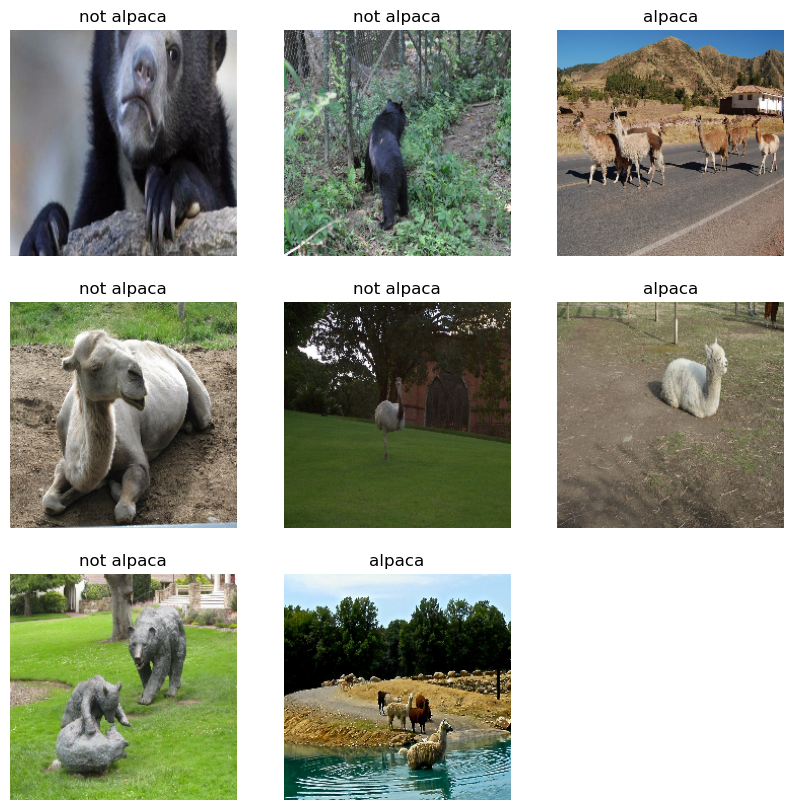

In [16]:
def make_prediction (image, model):
    resized = tf.image.resize([image], (224,224))
    inputs = tf.reshape(resized, (1, 224, 224, 3))
    y = model.predict(inputs)
    if y < 0.5:
        return "alpaca"
    else:
        return "not alpaca"

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(make_prediction(images[i], newmodel))
    plt.axis("off")


### Fine-tuning

In [72]:
base_model.trainable = True
newmodel.summary()

newmodel.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning ratea
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10 
newmodel.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[keras.callbacks.EarlyStopping(patience=3)])

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,829 (8.63 MB)

 Trainable params: 2,225,153 (8.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 2,564 (10.02 KB)

Epoch 1/10
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - binary_accuracy: 0.7077 - loss: 0.9123

2024-11-08 10:24:38.663134: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 40 bytes spill stores, 40 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 248 bytes spill stores, 248 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_and_reduce_fusion', 284 bytes spill stores, 284 bytes spill loads



17/17 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - binary_accuracy: 0.7068 - loss: 0.8975 - val_binary_accuracy: 0.9692 - val_loss: 0.1554
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - binary_accuracy: 0.7470 - loss: 0.6419 - val_binary_accuracy: 0.9692 - val_loss: 0.1707
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - binary_accuracy: 0.8773 - loss: 0.3396 - val_binary_accuracy: 0.9692 - val_loss: 0.1848
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - binary_accuracy: 0.8852 - loss: 0.2656 - val_binary_accuracy: 0.9538 - val_loss: 0.1969
